# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
train_files = np.array(glob("/data/dog_images/train/*/*"))
test_files = np.array(glob("/data/dog_images/test/*/*"))
valid_files = np.array(glob("/data/dog_images/valid/*/*"))

# print number of images in each subgroup
print('There are %d images in the training set.' % len(train_files))
print('There are %d images in the testing set.' % len(test_files))
print('There are %d images in the validation set.' % len(valid_files))

There are 6680 images in the training set.
There are 836 images in the testing set.
There are 835 images in the validation set.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


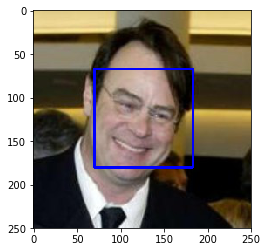

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
correct = 0
incorrect = 0
for human_file in human_files_short:
    if face_detector(human_file):
        correct += 1
print("Percentage of correctly identified human faces is %d%%"%(correct))
for dog_file in dog_files_short:
    if face_detector(dog_file):
        incorrect += 1
print("Percentage of incorrectly identified human faces in dog pictures is %d%%"%(incorrect))

Percentage of correctly identified human faces is 98%
Percentage of incorrectly identified human faces in dog pictures is 17%


The human face detector from OpenCV works quite well on detecting human faces, as seen above, and is less accurate when it comes to *not* identifying human faces in pictures of dogs. This is however a good enough face detector to go ahead with on the rest of the project.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

## I had to add these two lines to deal with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Loading the image with Pillow
    image = Image.open(img_path).convert('RGB')
    
    # Resize image to be 224x224 pixels to match VGG16 input shape and normalize
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         normalize])
    
    # Reshape dimensions to include a dimension for batch size
    image = data_transform(image).unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    # Get predicted category for image
    with torch.no_grad():
        output = VGG16(image)
        prediction = torch.argmax(output).item()
    
    return prediction # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    # Make aprediction
    pred_index = VGG16_predict(img_path)
    
    # Flag to check if dog is detected
    detected = False
    
    if pred_index >= 151 and pred_index <= 268:
        detected = True
    
    return detected # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

#### __Answer:__ 
Out of 100 images from the human face dataset, the "dog detector" code detects just one or zero dogs in the images (results change when I run the code multiple times, due to randomeness), which is the desired outcome. Out of the 100 dog images though, the dog detector gets between 97% and 100 % accuracy. This is impressive performance, so I decided to stick with VGG16 as the basis of my dog detector.


In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

correct = 0
incorrect = 0
for human_file in human_files_short:
    if dog_detector(human_file):
        incorrect += 1
print("Percentage of incorrectly identified dogs in images of human faces is %d%%"%(incorrect))
for dog_file in dog_files_short:
    if dog_detector(dog_file):
        correct += 1
print("Percentage of correctly identified dogs in dog pictures is %d%%"%(correct))

Percentage of incorrectly identified dogs in images of human faces is 1%
Percentage of correctly identified dogs in dog pictures is 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [17]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# Create data tranforms to augment the data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

data_transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.RandomAffine(10),
                                           transforms.ToTensor(),
                                           normalize])

data_transform_valid = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           normalize])

data_transform_test = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          normalize])

# Point to the train, validation, and test datasets
train_dir = "/data/dog_images/train/"
valid_dir = "/data/dog_images/valid/"
test_dir = "/data/dog_images/test/"

train_data = datasets.ImageFolder(train_dir, transform=data_transform_train)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform_valid)
test_data = datasets.ImageFolder(test_dir, transform=data_transform_test)

# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
                                           
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?  
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: This is the reasoning I had for the data preprocessing. First, all the images had to be the same height and width (224 x 224), irrespective of whether they came from the training, validation, or test dataset, because this is the input size expected by the VGG16 architecture, and also for the architecture I plan to build from scratch. Secondly, all images had to be normalized the same way.  
Since each category of dog breed in the dataset has about 20 to 60 images, I decided a bit of data augmentation might help the model with generalization. So, for the training data loader, I preprocess the data by randomly resizing and cropping a 224 x 224 sized window. I then add a transform to randomly flip the image horizontally with a probability of 0.5. Finally I add a transform to randomly rotate the images between +10 and -10 degrees. These transforms should ensure a greater diversity of image data per class, and hence should help the model generalize better to unseen data while training. I do not add these transforms to the validation and test data loader as it this data is not used to train the network and hence adding diversity information here is unnecessary.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28x28x32 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 14 * 14 -> 25088)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        # linear layer (512 -> 256)
        self.fc2 = nn.Linear(512, 256)
        # linear layer (256 -> 133)
        self.fc3 = nn.Linear(256, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 128 * 14 * 14)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer, with linear activation function
        x = self.fc3(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ I started of by using the same architecture used in the Cifar10 dataset classification example in the Udacity Machine Learning Nanodegree extracurricular notes. This architecture used 3 convolutional layers, each with filters of size 3x3 and same padding. Each of these 3 convolutional layers was followed by a 2x2 max pooling layer with stride 2, effectively halving the output size of the previous layer. After the convolutional layers, the output was flattened and sent through two fully connected layers to the output prediction layer. This architecture also made use of dropout at the fully connected layers, with a dropout probaility of 25%. The outputs of every convolutional layer, as well as every fully connected layer except the last, were fed through a RELu activation before being propagated to the next layer.  
I believed this would be a good enough starting point. However on second thoughts, I added another convolutional layer and another fully connected layer, since the task of classifiying dog breeds is more complex, and hence would require both a deeper feature extraction pipeline as well as a more complex classifier function.

In [12]:
!pip install torchsummary

In [13]:
from torchsummary import summary

In [14]:
summary(model_scratch, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
         MaxPool2d-8          [-1, 128, 14, 14]               0
           Dropout-9                [-1, 25088]               0
           Linear-10                  [-1, 512]      12,845,568
          Dropout-11                  [-1, 512]               0
           Linear-12                  [-1, 256]         131,328
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [15]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch =  optim.Adam(model_scratch.parameters(), lr=0.001)

I chose the cross entropy loss here, because this ensures that the output of the neural network is converted into a probability using a softmax operation, and then converted into a log probability and used to caclulate the loss, all in a single line of code. I also chose the ADAM optimizer instead of a vanilla gradient descent optimizer. ADAM has shown to be a superior optimizer in several computer vision applications and challenges. It is faster and more robust to local minima in the loss curve.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [18]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.881643 	Validation Loss: 4.844302
Validation loss decreased (inf --> 4.844302).  Saving model ...
Epoch: 2 	Training Loss: 4.781144 	Validation Loss: 4.704274
Validation loss decreased (4.844302 --> 4.704274).  Saving model ...
Epoch: 3 	Training Loss: 4.649878 	Validation Loss: 4.547458
Validation loss decreased (4.704274 --> 4.547458).  Saving model ...
Epoch: 4 	Training Loss: 4.538345 	Validation Loss: 4.418596
Validation loss decreased (4.547458 --> 4.418596).  Saving model ...
Epoch: 5 	Training Loss: 4.455124 	Validation Loss: 4.359479
Validation loss decreased (4.418596 --> 4.359479).  Saving model ...
Epoch: 6 	Training Loss: 4.411462 	Validation Loss: 4.371864
Epoch: 7 	Training Loss: 4.365197 	Validation Loss: 4.279943
Validation loss decreased (4.359479 --> 4.279943).  Saving model ...
Epoch: 8 	Training Loss: 4.312121 	Validation Loss: 4.211863
Validation loss decreased (4.279943 --> 4.211863).  Saving model ...
Epoch: 9 	Training Loss: 4.306530 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.605116


Test Accuracy: 13% (116/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

I decided to go with the same loaders from the previous step.

In [20]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [25]:
Resnet50 = models.resnet50(pretrained=True)

if use_cuda:
    Resnet50.cuda()

In [26]:
print(Resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

From the model summary of the ResNet0 classifier, it is apparent that the last layer of the network, i.e. layer "fc" of the network, is the output layer of the original, pre-trained ResNet50 network. This layer in the original network has an output vector of length 1000 corresponding to the 1000 classes in the ImageNet dataset. This is the layer I will replace and fine tune for the dog breed classifier.  
The convolutional and pooling layers of this network are extremely well trained and precise feature extractors, so I do not want to train them any more while fine tuning the detector. Therefore I will freeze their weights. The only layer whose weights I will fine-tune will be the last, fully connected layer.

In [27]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

model_transfer = models.resnet50(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False

# Get inputs to the last layer
n_inputs = model_transfer.fc.in_features

# add last linear layer (n_inputs -> 133 dog classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 133)

model_transfer.fc = last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I spent quite some time on this part of the project. The first thing I tried was to use the VGG16 network for transfer learning. I replaced the final, fully-connected layer of the VGG16 network with a new fully connected layer with 133 output nodes, froze the weights of all layers except for the last fully connected layer, and then trained this new network on the dog dataset. I was negatively surprised with the results of this. I wasn't able to get an accuracy beyond 40%, with this network. I am still not sure why the pre-trained VGG16 network did not perform well with transfer learning, but if I had to guess, I would say it is because the fully connected layers of the pre-trained VGG model were "overfit" in away to the original ImageNet dataset, and couldn't be fine-tuned to the new dog breeds dataset in a reasonable number of iterations. I suppose one way of overcoming this would be to replace the entire fully connected part of the pre-trained VGG16 model, or at least more of the fully connected layers than just the last layer. However, I decided instead to try my luck with a different pre-trained network first.  
I chose the ResNet50 next, for several reasons. First, ResNet50 achieved a higher accuracy on the original ImageNet dataset than VGG16 (about 93.3% vs 91.9%). This would imply that ResNet50 has a better feature exraction pipeline than VGG16. Secondly, ResNet50 has an architecture that comprises of residual connections and many deep layers, compared to VGG16's straightforward convolutional + fully connected architecture. This gives ResNet50 an advantage of strengthening feature propagation from the original image data to the later layers. With these general thoughts in mind, I tried transfer learning with the pre-trained ResNet50 model, simply replacing the last fully connected layer with my own, and training the weights on just this layer. This was enough to give me an accuracy of 83% in 10 epochs.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [29]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [30]:
# train the model
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.707175 	Validation Loss: 1.395571
Validation loss decreased (inf --> 1.395571).  Saving model ...
Epoch: 2 	Training Loss: 1.450781 	Validation Loss: 1.087392
Validation loss decreased (1.395571 --> 1.087392).  Saving model ...
Epoch: 3 	Training Loss: 1.253954 	Validation Loss: 1.002909
Validation loss decreased (1.087392 --> 1.002909).  Saving model ...
Epoch: 4 	Training Loss: 1.163984 	Validation Loss: 0.850993
Validation loss decreased (1.002909 --> 0.850993).  Saving model ...
Epoch: 5 	Training Loss: 1.152550 	Validation Loss: 0.865183
Epoch: 6 	Training Loss: 1.079967 	Validation Loss: 0.814526
Validation loss decreased (0.850993 --> 0.814526).  Saving model ...
Epoch: 7 	Training Loss: 1.080612 	Validation Loss: 0.880853
Epoch: 8 	Training Loss: 1.028761 	Validation Loss: 0.778923
Validation loss decreased (0.814526 --> 0.778923).  Saving model ...
Epoch: 9 	Training Loss: 1.050806 	Validation Loss: 0.827240
Epoch: 10 	Training Loss: 1.064127 	Valida

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [31]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.550256


Test Accuracy: 83% (698/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [33]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    # Loading the image with Pillow
    image = Image.open(img_path).convert('RGB')
    
    # Resize image to be 224x224 pixels to match VGG16 input shape
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         normalize])
    
    # Reshape dimensions to include a dimension for batch size
    image = data_transform(image).unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    # Get predicted category for image
    with torch.no_grad():
        output = model_transfer(image)
        prediction = torch.argmax(output).item()
    
    return class_names[prediction]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [34]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    if face_detector(img_path):
        print("Hello, human!")
        
        img = cv2.imread(img_path)
        
        # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # display the image
        plt.imshow(cv_rgb)
        plt.show()
        
        print("You look like a ...")
        
        print(predict_breed_transfer(img_path))
        
    elif dog_detector(img_path):
        print(" Hello, doggie!")
        
        img = cv2.imread(img_path)
        
        # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # display the image
        plt.imshow(cv_rgb)
        plt.show()
        
        print("This dog is a ...")
        
        print(predict_breed_transfer(img_path))
    
    else:
        print("Neither human faces nor dogs detected! Error!")
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is as good as I expected it to be. Some possible ways of improving it would be:
1. Training the transfer-learned model for more epochs. There was a downward trend of training and validation loss when I stopped the training, so I assume I could further improve the accuracy just by training longer.
2. Using a larger dataset / more data augmentation. There are many web-scraping libraries I could use to get hundreds more images of various dog breeds from Google searches, and add this to my data library. Also, augmentation techniques such as tweaking the image brightness, saturation and hue, or random rotations, or random grayscaling etc would result in training a network that is far better at generalizing to unseen test data.
3. Doing some research on different pre-trained networks to use as a starting point. I looked at the VGG16 network and ResNet50, but there are several others, such as ResNet152, Inceptionv3 etc, that could potentially give better results.
4. More hyperparameter tuning. Maybe using an adaptive learning rate, or some kind of learning rate scheduler. Maybe using a different optimizer than Adam (Nadam for instance seems quite promising). Or even adding more layers to the end of the network, with different activation functions etc. There is a lot of trial and error based optimization that can be done here.

Hello, human!


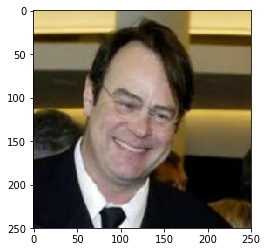

You look like a ...
Chihuahua
Hello, human!


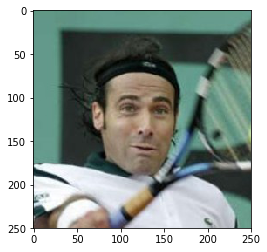

You look like a ...
Doberman pinscher
Hello, human!


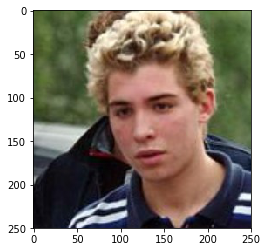

You look like a ...
American water spaniel
 Hello, doggie!


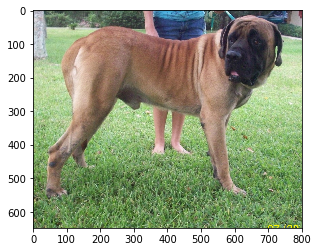

This dog is a ...
Mastiff
 Hello, doggie!


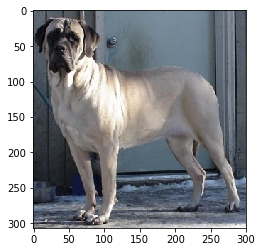

This dog is a ...
Mastiff
 Hello, doggie!


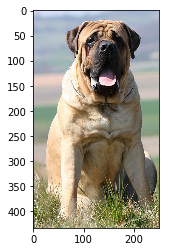

This dog is a ...
Cane corso


In [35]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

Hello, human!


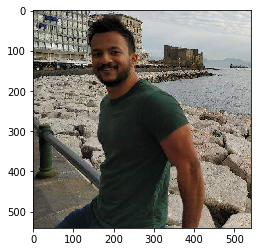

You look like a ...
Doberman pinscher
Hello, human!


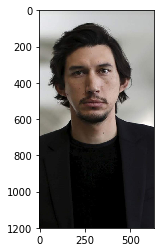

You look like a ...
Doberman pinscher
Hello, human!


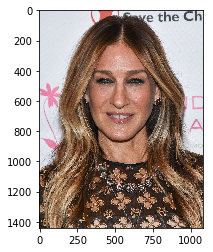

You look like a ...
Welsh springer spaniel
 Hello, doggie!


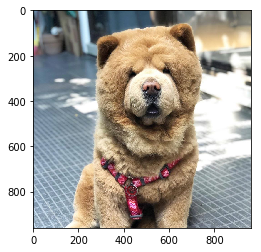

This dog is a ...
Chinese shar-pei
 Hello, doggie!


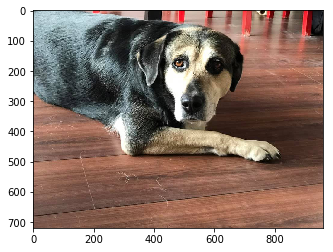

This dog is a ...
American foxhound
 Hello, doggie!


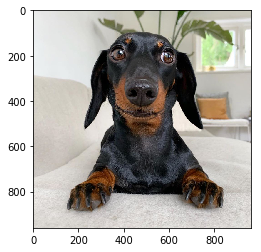

This dog is a ...
German pinscher


In [37]:
my_images = np.array(glob("my_images/*.jpg"))

for file in my_images:
    run_app(file)